In [83]:
%%capture
# The above line blocks annoying comments from Pygame. It has to stay at the very top of this block.

# Initial Setup
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from jupyter_scrn import *

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('xtick', labelsize=36) 
mpl.rc('ytick', labelsize=36) 

import pandas as pd

## Step 1 Name this Run of the Simulator

First, make sure you've run the code block above.

Define the name of the directory to store the results by changing `RESULTS_PATH` and `RUN_NUM`. `RESULTS_PATH` will store things you have on the machine. `RUN_NUM` part of the directory name differentiates the different runs of the same simulation.

Set `DEV_MODE` to `True` till you're satisfied with the figures. Then set it to `False`, take a rest, and wait for much smoother graphs.

If `DEV_MODE` is set to `False`, the Surface CRN will use a 20 by 20 grid.

In [84]:
RUN_NUM = 1

DEV_MODE = True

if DEV_MODE:
    grid_annotation = "10 by 10"
else:
    grid_annotation = "20 by 20"
    
    
RESULTS_PATH = "High Pressure Results {}st Run - {} Grid".format(RUN_NUM, grid_annotation)


try:
    os.mkdir(RESULTS_PATH)
except OSError:
    print ("Creation of the directory {} failed".format(RESULTS_PATH))    

## Step 2 Define the Reaction System

Supply the reaction rules. Be sure to double check that the rates are correct.

You may change random number seed `rng_seed` once in a while. The Surface CRN is probabilistic; changing the random number seed may have some effect on the final results.

In [85]:
rules = """
# Run settings
pixels_per_node    = 50
speedup_factor     = 0.5
debug              = True
rng_seed           = 923123122
max_duration       = 10000
fps                = 60
node_display       = text
wrap               = false

!START_TRANSITION_RULES
# Condition 2:
# Temperature = 298K, Pressure = 1E-1 torr = 1.33E-1 mbar
# Binding energy:  
# H2O* = 532.2
# OH* = 530.9 
# O* = 530.0
# H2O_OH_hb = 531.6
# H2O_O_hb = 531.6
# H2Omulti = 533.2

(3.207654) O*    -> H2O_O_hb
(1.363342) OH* -> H2O_OH_hb

# Reversible reaction
(6.220646) H2O_O_hb + Ni -> OH* + OH*
(0.160755) OH* + OH* -> H2O_O_hb + Ni

(0.299507) H2O_OH_hb + Ni -> H2O* + OH* 
(0.167130) H2O_O_hb + Ni -> H2O* + O* 
# Main reaction 1
(1.939313) H2O* -> Ni
(0.515646) Ni -> H2O*

(0.733491) H2O_OH_hb ->  OH*
(0.311754) H2O_O_hb ->  O*

(1.038423) H2O_OH_hb  ->  H2Omulti

(0.962999) H2Omulti -> H2O_OH_hb

# Reversible reaction
(0.002342) O* + O* ->   Ni + Ni
# Main reaction 2
(426.922895) Ni + Ni -> O* + O*


# TODO: The following lines are tentative. Make sure these are correct.

# Additional diffusion specific for the surface CRN
(3) Ni + O* -> Ni + O*
(3) Ni + OH* -> Ni + OH*
(3) Ni + H2O* -> Ni + H2O*

# The following rules are specific for the 3F sites.
(10) OH*_top + 3F -> Ni + OH*_3F
(0.5) Ni + OH*_3F -> OH*_top + 3F

(10) O*_top + 3F -> Ni + O*_3F
(0.5) Ni + O*_3F -> O*_top + 3F

!END_TRANSITION_RULES

# Initial state
!START_INIT_STATE
# TO BE HARD CODED AND RETURNED BY CODE
Ni Ni
!END_INIT_STATE

# Colormap
!START_COLORMAP
Ni: (160,160,160)
{Intersection}   I: (200, 200, 0)
!END_COLORMAP

"""

# We need our own custom grid!

In [86]:
def save_rules(rules, filename="tmp_reaction_rules.txt"):
    """
    Save the rules defined here as a text file. 
    
    Replace calls to this function with your filename if you already have a text file in the same 
    directory as this notebook.
    """
    with open(filename,"w") as f:
        f.write(rules)
    return filename

rules_file = save_rules(rules, "high_pressure_reaction_rules.txt")

Feel free to edit the reaction rules elsewhere. In that case, we need only the filename here.

In [87]:
# rules_file = "low_pressure_reaction_rules.txt"

## Step 3 Customize the Surface

The Surface CRN defaults to a square grid that you could have defined as the `rules` variable above or in a separate `txt` file. The grid should also represent where the initial species are located. 

If you'd like to define a different surface structure, hard code the structure here.

In [88]:
def produce_initial_surface():
    """
    Returns a hard-coded surface for the reaction, populated with initial concentrations.
    
    This will replace the initial state supplied in the text file (a.k.a. the file for rules).
    """
    
    # Initiate the default surface structure. In general, a 10 by 10 grid can be simulated in 1 minute; 
    # a 20 by 20 grid will take some wait, but the resulting spectrum is much smoother.
    if DEV_MODE:
        surface = HexGridPlusIntersections(10, 10)
    else:
        surface = HexGridPlusIntersections(20, 20)
    
    # Popultate the structure with initial atoms.     
    for n in surface:
        if n.is_intersection:
            if random.random() < 0.25:
                n.state = "O*"
            else:
                n.state = "3F"
        else:
            n.state = "Ni"
    return surface

surface = produce_initial_surface()

## Step 4 the Secret Sausage

Run the Surface CRN. You need to give it a list of species to track.

In [89]:
species = ["H2Omulti", "H2O*", "H2O_O_hb", "H2O_OH_hb", "O*", "OH*"]

In [90]:
%%capture
# The above line suppresses the Surface CRN's printing of the initial setup as it understands it. It has to
# be the very first line of this block.
# These messages may come of use if you suspect the Surface CRN is incorrectly understanding your input.
times, concs = simulate_without_display(rules_file, surface, species)

## Step 5 The Results and the Art of Plotting

Now sum up all the subspecies into a seperate entry in `concs`.

In [91]:
# A dictionary from a species to its subspecies.
sub_species_dict = {"H2O_hb": ["H2O_O_hb", "H2O_OH_hb"]}

def sum_sub_species(concs, sub_species_dict):
    """
    Produce the total concentration for each species in sub_species_dict.
    
    Append the resulting series of total concentration to concs.
    """
    for k, v in sub_species_dict.items():
        conc = []
        for i in range(len(list(concs.values())[0])):
            c = 0
            for species in v:
                c += concs[species][i]
            conc.append(c)
        concs[k] = conc
        
sum_sub_species(concs, sub_species_dict)

Specify the species you'd like to display and the colors for each of them.

The plotter will plot with all species from the `species_in_figure` list, and then with all but the first species. This way, you may clearly see how species with way smaller molecular counts evolve over time.

In [109]:
# A list of species to display, best by the order of rough concentration levels. Species that are orders
# of magnitude more should be in the front.
# All species
# species_in_figure = ["O*", "H2O*", "OH*", "H2O_hb", "H2Omulti", "H2O_O_hb", "H2O_OH_hb"]
# Colors to use for each species, 1st color is for the 1st species, etc.
spanish_grey, fire_engine_red = "#989898", "#CE2029"
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',  fire_engine_red, spanish_grey, '#bcbd22', '#17becf']

You can calculuate the order of species by final concentration values here and then make modifications to `species_in_figure`. 

In [112]:
def rank_by_final_value(concs):
    """
    Return a list of species ranked by their final concentration value.
    
    Final concentration, for the purposes here, is defined as the average of the last 100 values in a time series.
    """
    species = list(concs.keys())
    species.sort(reverse=True, key=lambda k: sum(concs[k][-100:]) / 100)
    return species

rank_by_final_value(concs)

['O*', 'H2Omulti', 'H2O*', 'H2O_O_hb', 'H2O_OH_hb', 'OH*', 'H2O_hb']

In [116]:
# Best for high pressure example.
species_in_figure = ['H2O_hb','H2Omulti', 'O*', 'OH*', 'H2O*']
# Best for the low pressure example.
species_in_figure = ['O*', 'H2Omulti', 'H2O*', 'OH*', 'H2O_hb']

In [117]:
def plot(concs, times, name="Entire Reaction", end_time=-1):
    """
    Plot the concentrations until time step end_time. -1 means till the end.
    
    Name is the specifc name of this plot.
    """
    if end_time == -1:
        end_step_num = len(times)
    else:
        end_step_num = 0
        while end_step_num < len(times) and times[end_step_num] < end_time:
            end_step_num += 1
        
    
    fig = plt.figure(figsize=(50,100))
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Evolution of H2O on Ni(111) System {}".format(name), fontsize=48)
    for i in range(len(species_in_figure) - 1):
        plt.subplot(len(species_in_figure) , 1, i + 1)
        for j in range(i, len(species_in_figure)):
            species = species_in_figure[j]
            plt.plot(times[:end_step_num], concs[species][:end_step_num], colors[j], label=species, linewidth=5)
            plt.legend(fontsize=36, numpoints=30)

        plt.xlabel("Time (s)", fontsize=36)
        plt.ylabel("Molecule Count (#)", fontsize=36)

    fig.savefig("{}/{}".format(RESULTS_PATH, name))

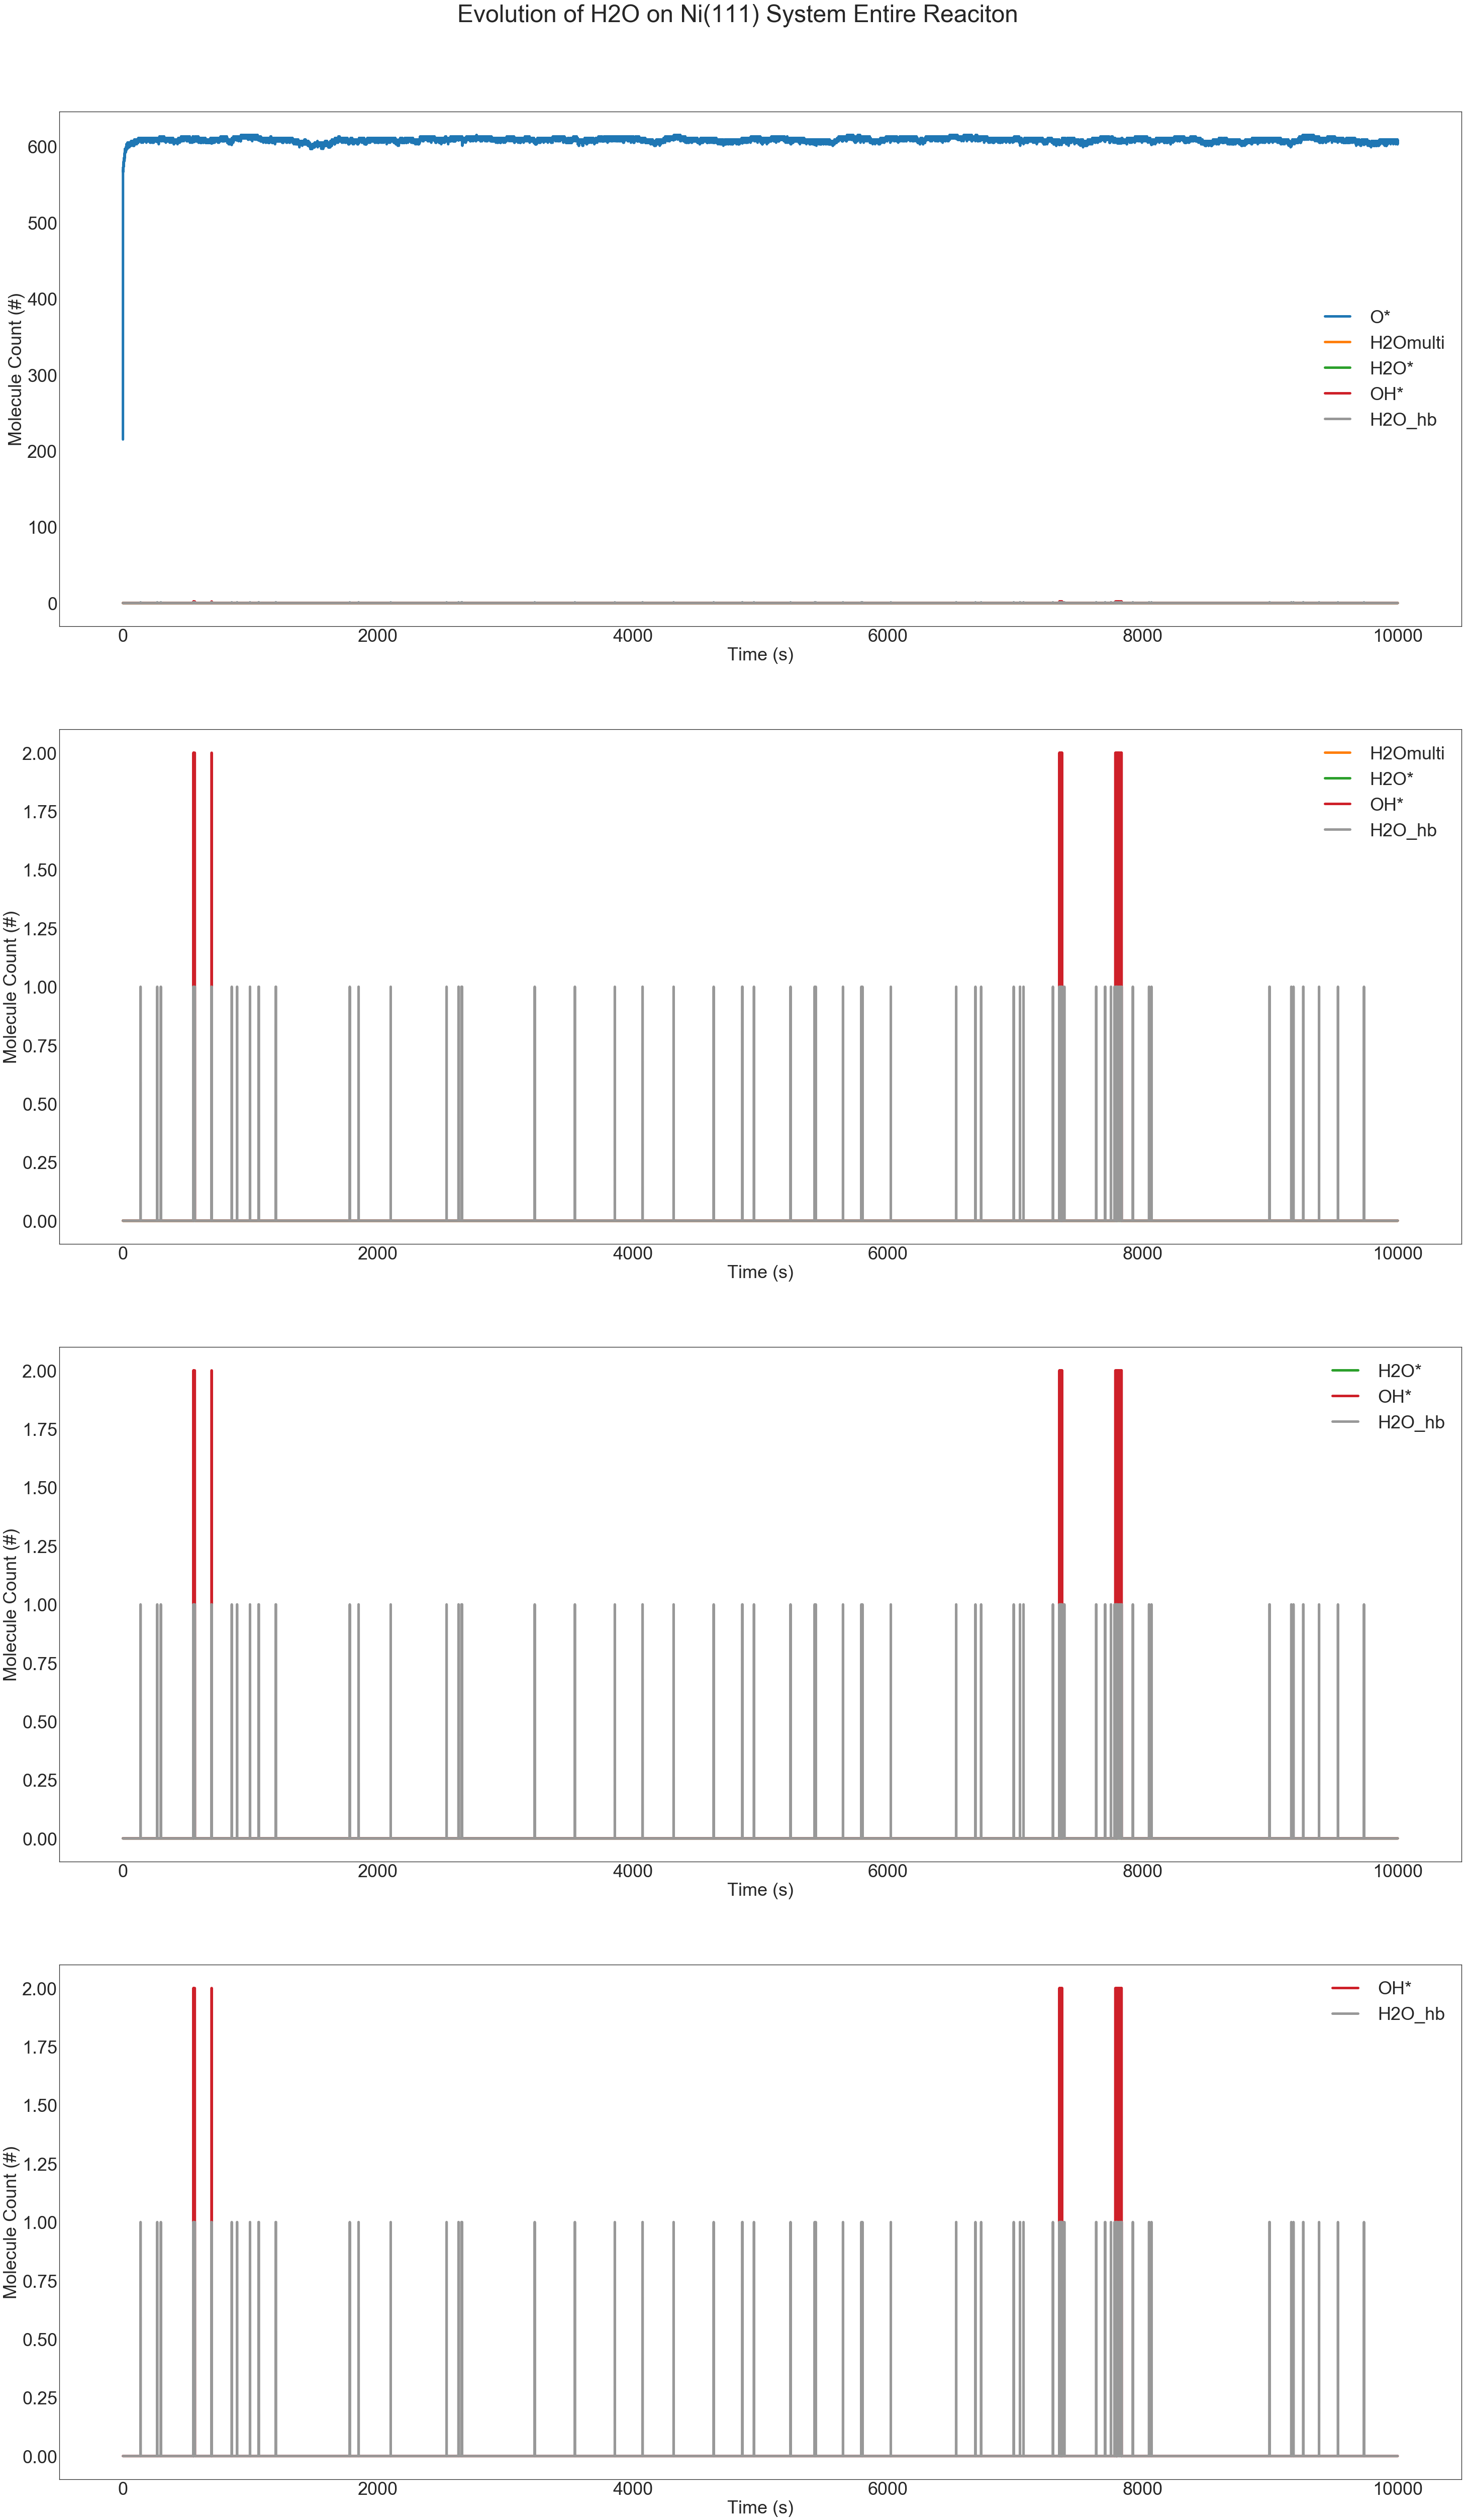

In [118]:
plot(concs, times, name="Entire Reaciton")

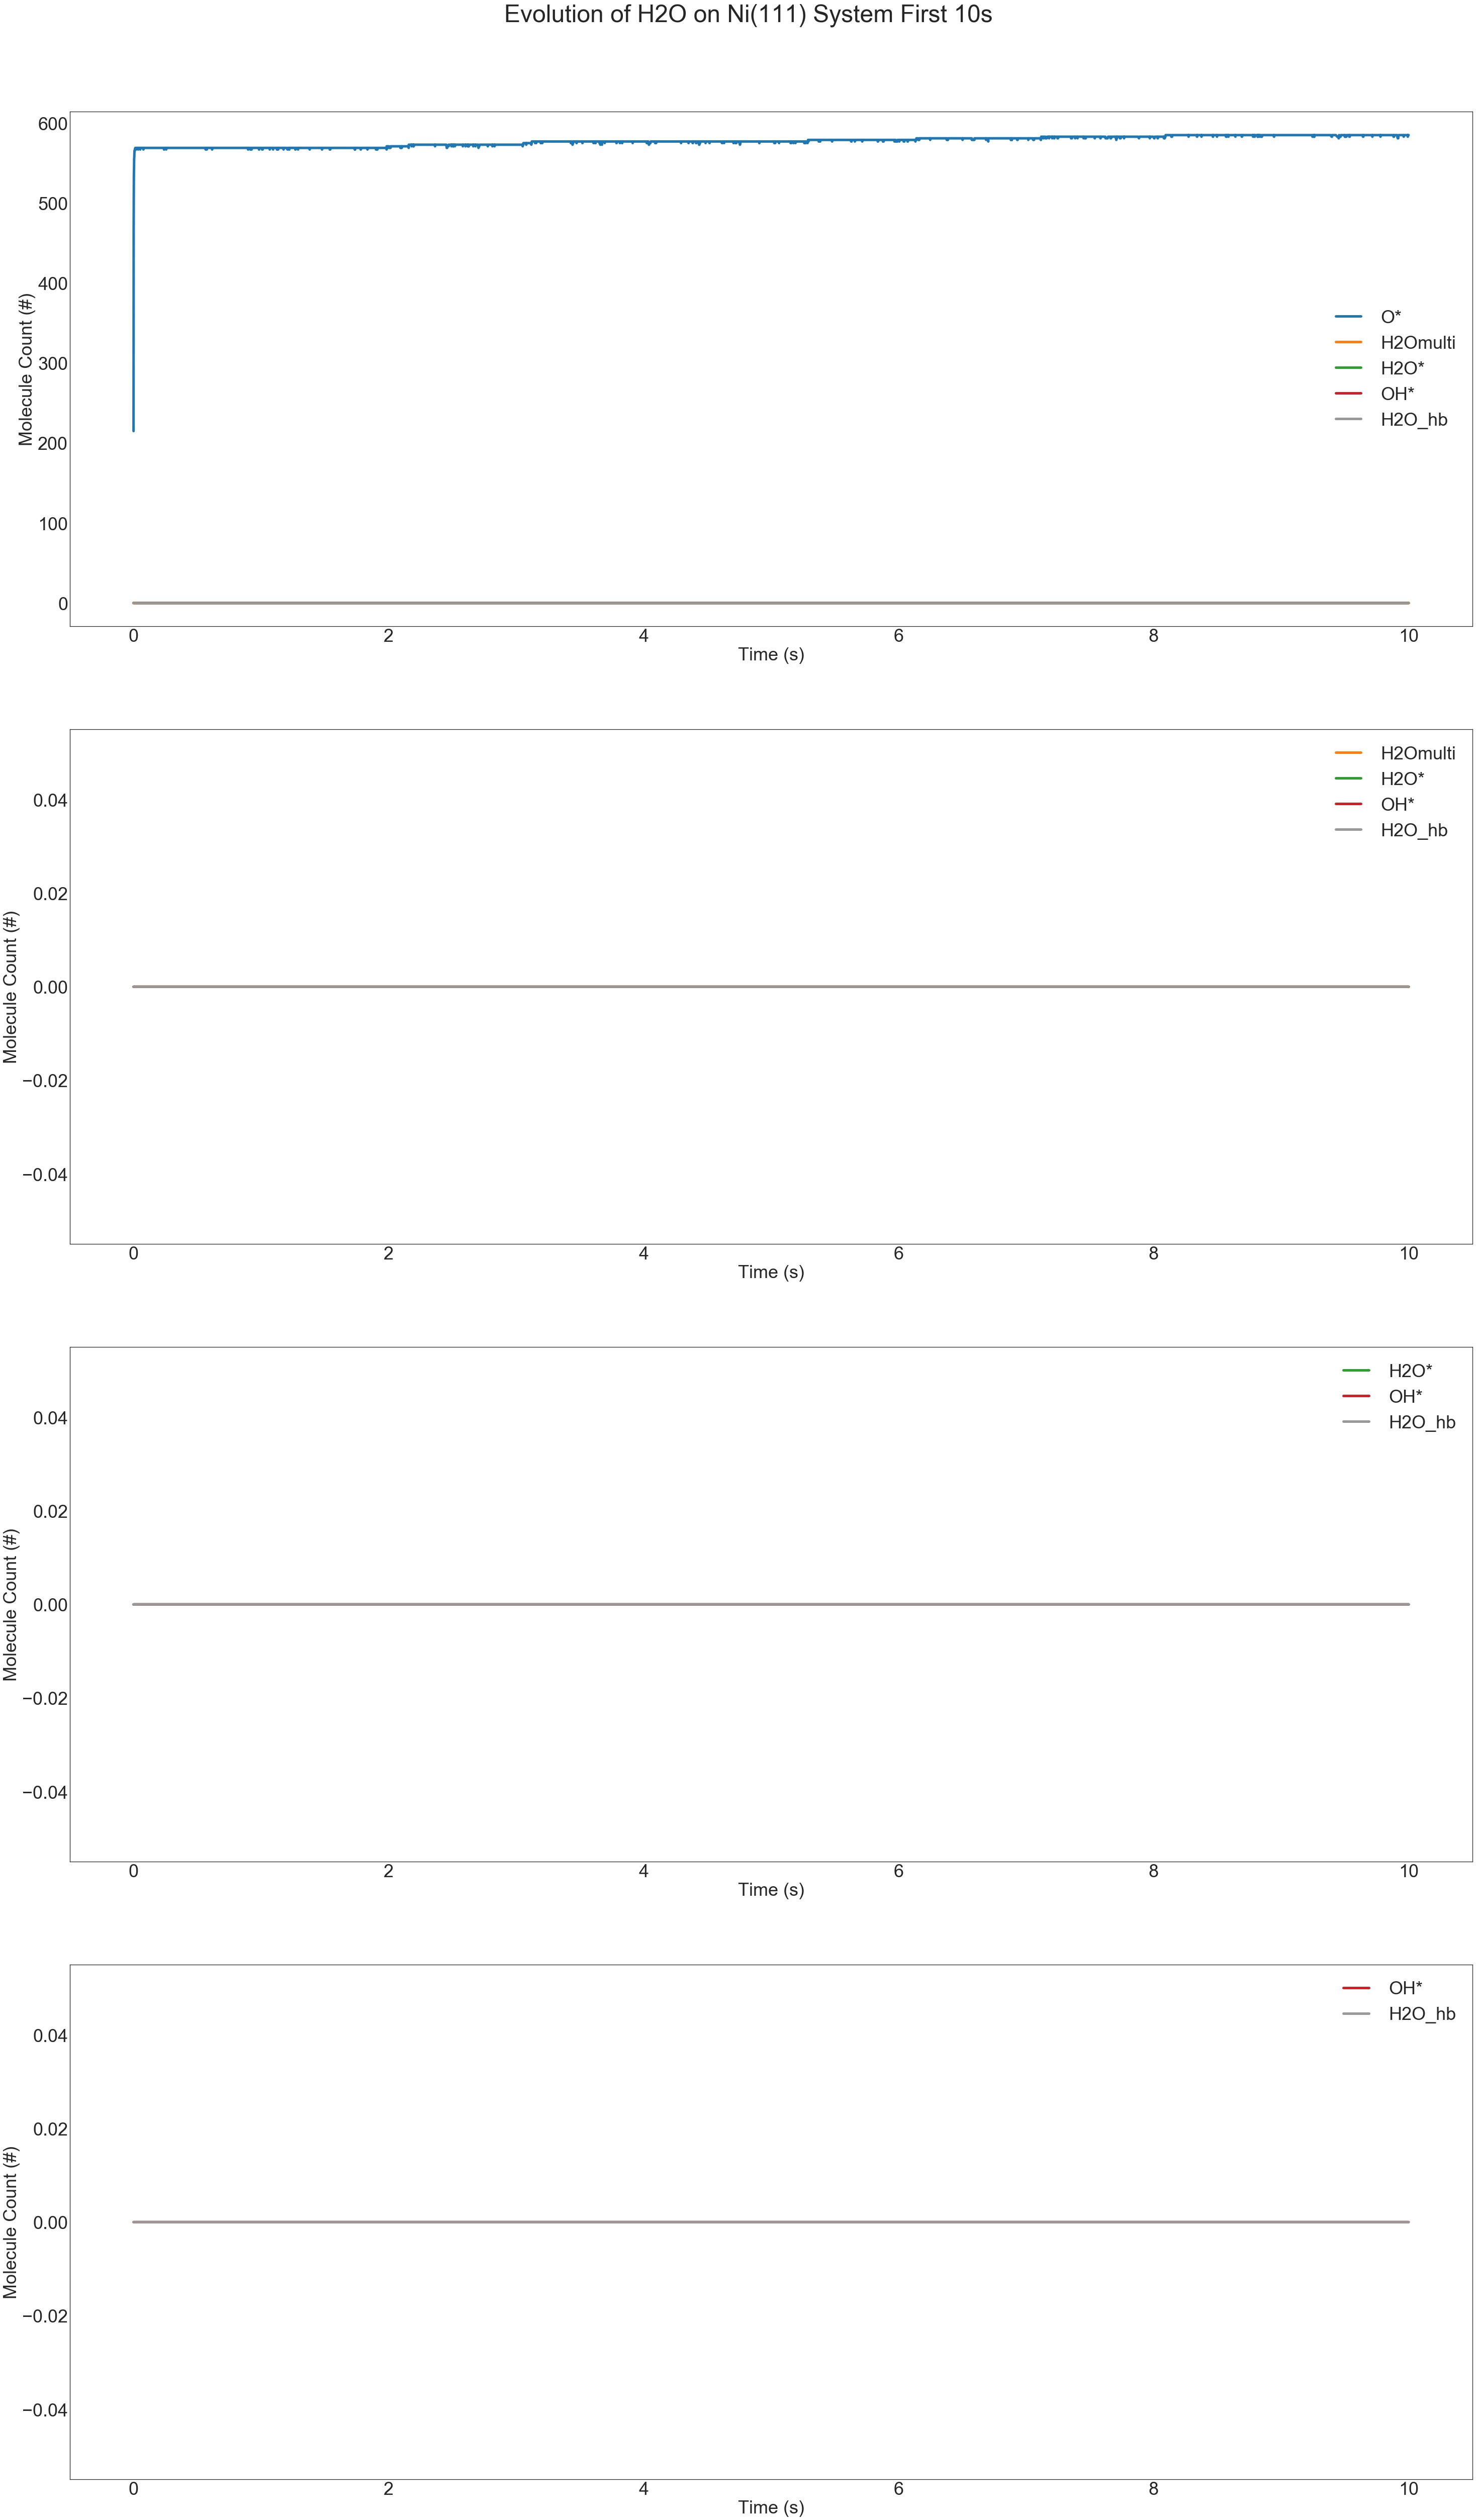

In [107]:
plot(concs, times, name="First 10s", end_time=10)

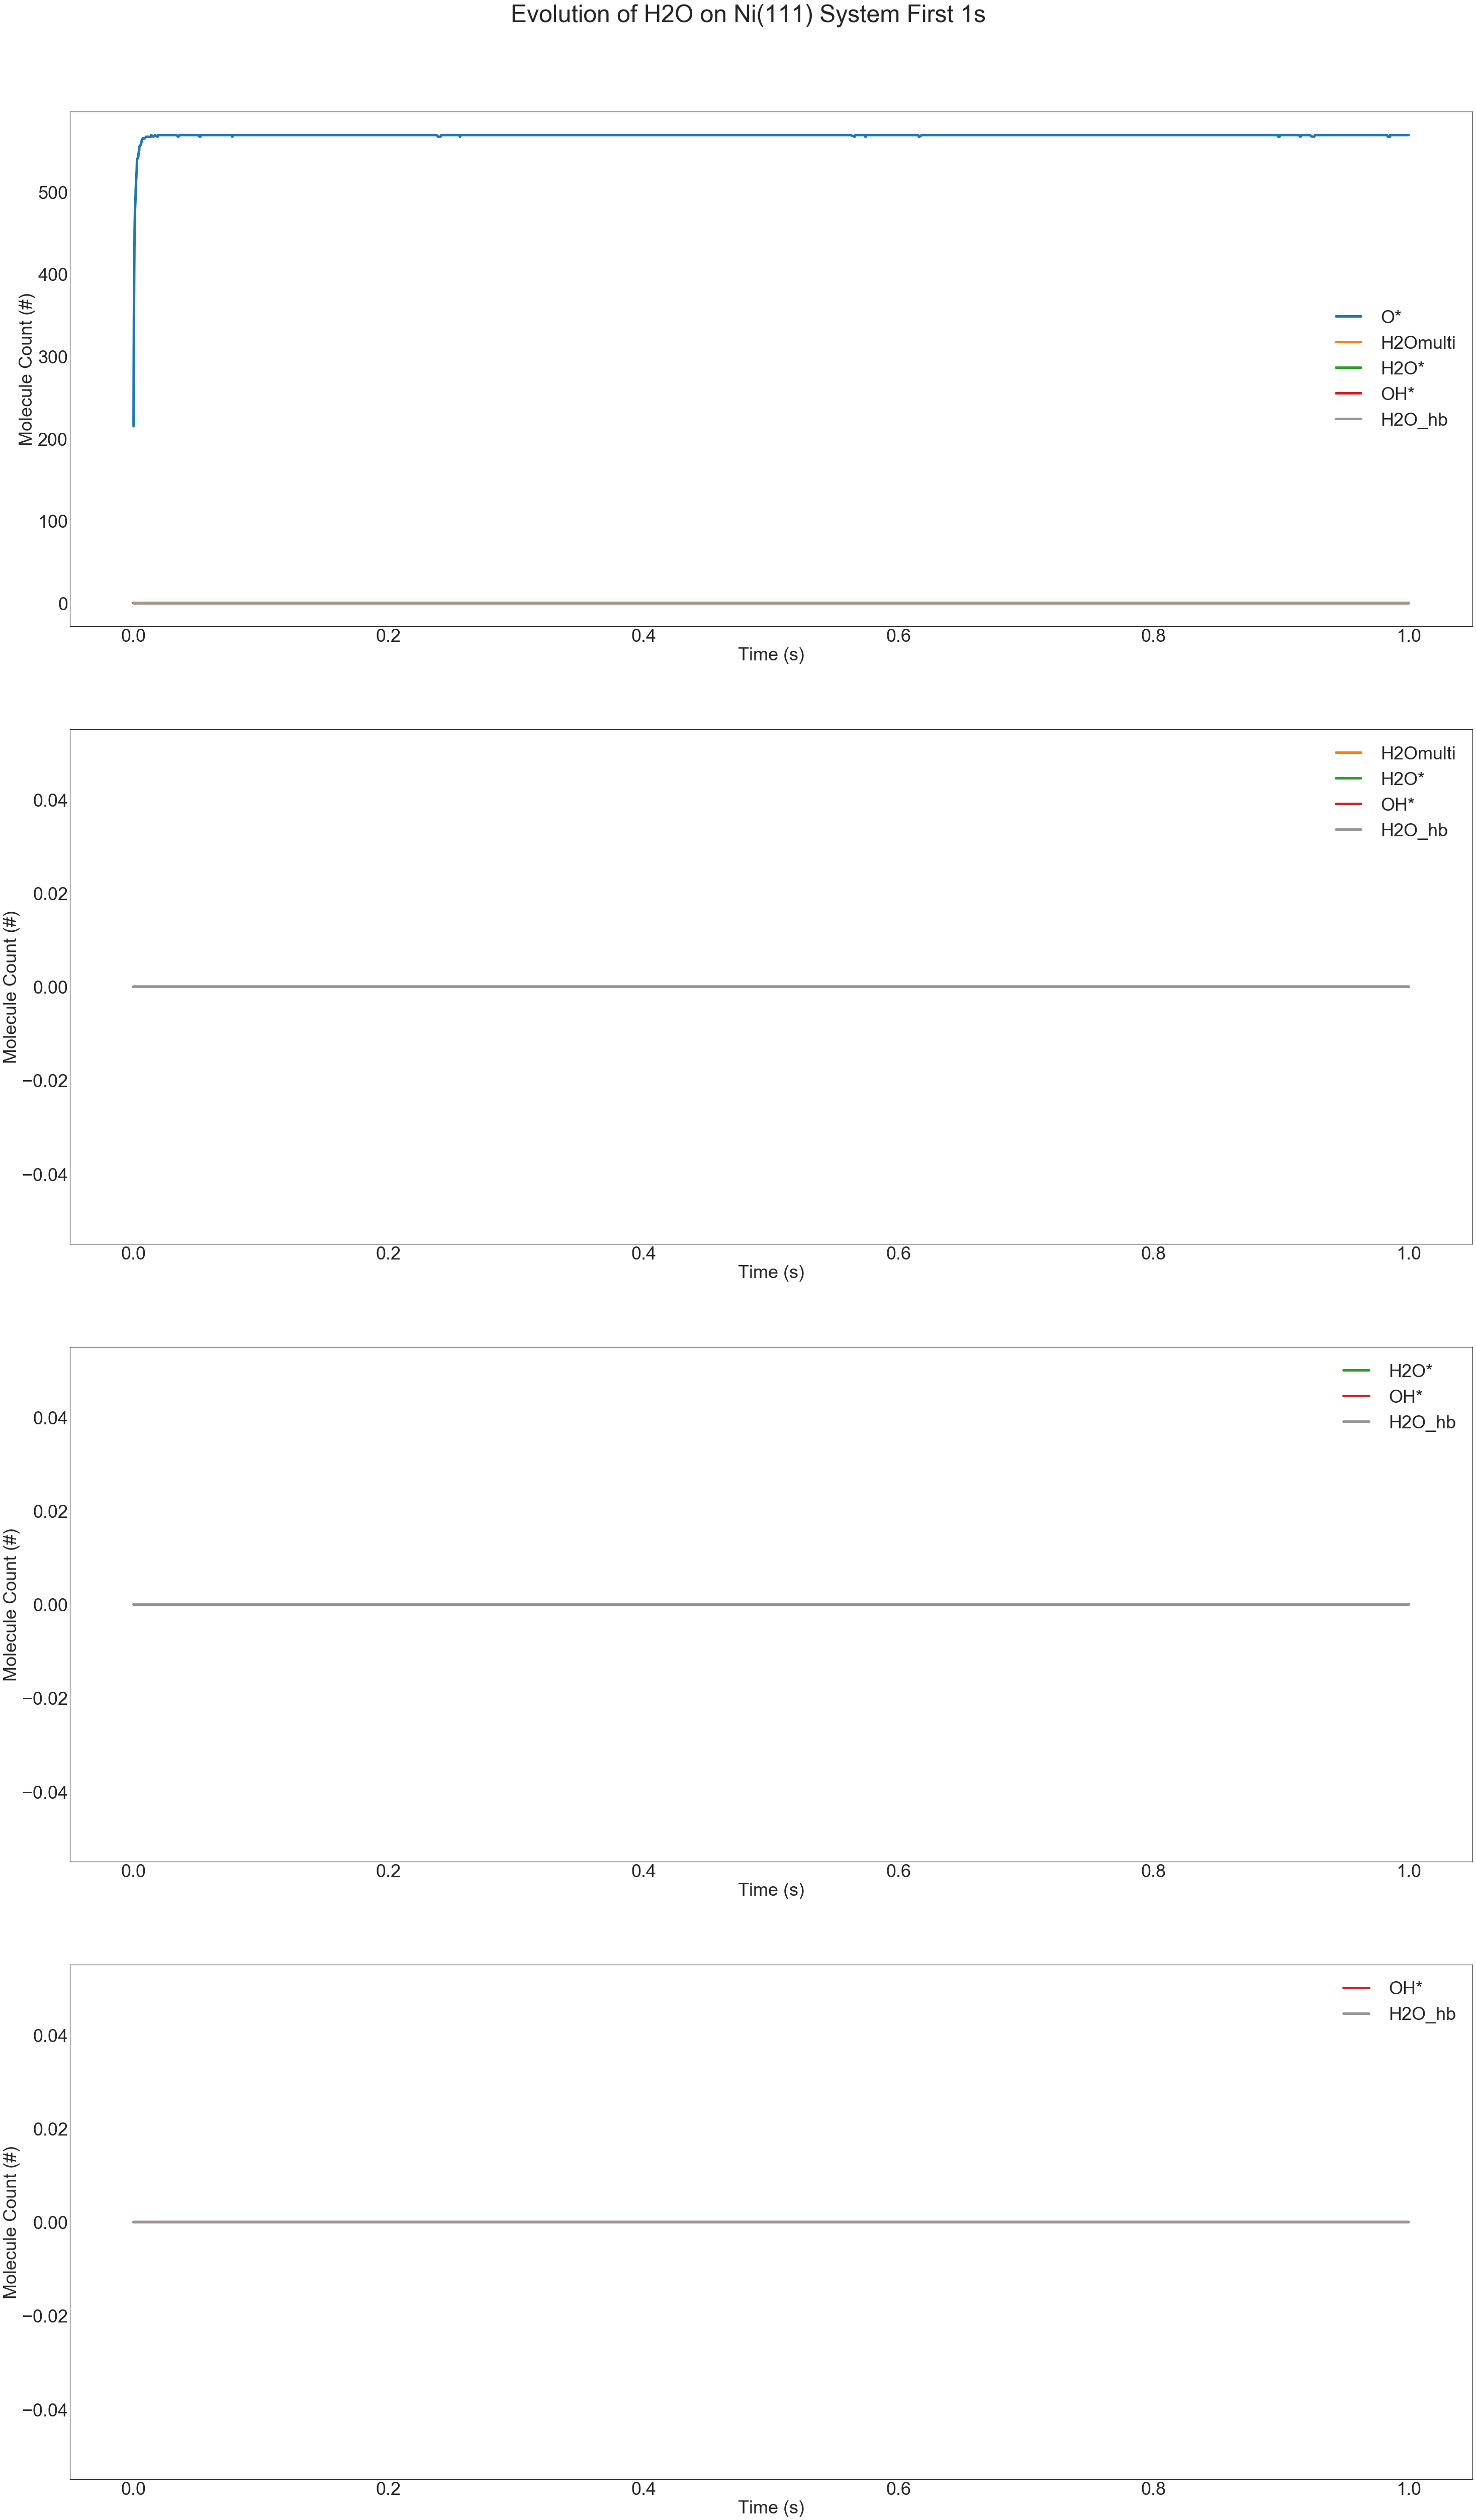

In [108]:
plot(concs, times, name="First 1s", end_time=1)

Now, we save the data for any future use.

In [99]:
df = pd.DataFrame.from_dict(concs)
df.insert(0, "Time (s) ", times)
df.to_csv("{}/Data".format(RESULTS_PATH))

## Step 5 Optional: Save the final values

Observe the figures in Step 4 and define a time after which the molecular counts for all species converge. 

In [100]:
CONVERGENCE_TIME = 9800

In [101]:
def compute_converged_values(times, concs, t):
    """
    Average all the values after time step t.
    """
    i = len(times) - 1
    while i >= 0 and times[i] > t:
        i -= 1
        
    averaged_results = {}
    for k, v in concs.items():
        averaged_results[k] = sum(v[i:]) / (len(times) - i)
    
    return averaged_results

In [102]:
final_values = compute_converged_values(times, concs, CONVERGENCE_TIME)
final_values

{'H2Omulti': 0.0,
 'H2O*': 0.0,
 'H2O_O_hb': 0.0,
 'H2O_OH_hb': 0.0,
 'O*': 607.5138278002048,
 'OH*': 0.0,
 'H2O_hb': 0.0}

A `csv` file for this set of final values is saved in `RESULTS_PATH/Final Values`

In [103]:
df = pd.DataFrame(final_values.items(), columns=['Species', 'Molecular Count'])
df.to_csv("{}/Final Values".format(RESULTS_PATH))